In [1]:
%load_ext autoreload
%autoreload 2

# imports
import time

# library imports
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pacswg.timer import TimerClass
import pacswg

from exp_trace_utils import get_time_with_tz
import exp_trace_utils

In [2]:
# configs
server_address = 'http://localhost:3000'

# service_name = 'tfserving-resnetv2'
# slo_timeout = 

# service_name = 'bentoml-onnx-resnet50'
# slo_timeout = 

service_name = 'bentoml-iris'
service_url = f'{server_address}/proxy/{service_name}'
slo_timeout = 500
initial_batch_size = 5
bs_config = {
    'max_bs': 100,
    'min_bs': 1,
    'inc_step': 5,
    'dec_mult': 0.7,
}
average_timeout_ratio_threshold = 0.5

# service_name = 'tfserving-mobilenetv1'
# slo_timeout = 

# SLO Target
slo_target = slo_timeout * 0.8

# length of measurements used to estimate different batch size response times
upstream_rt_max_len = 1000

# disable controller?
disable_controller = True
if disable_controller:
    initial_batch_size = 1

# experiment info
cpu_m = 1000
ram_mb = 1000
base_rps = 50
rps_list = [base_rps] * 5 + [base_rps*2] * 5 + [base_rps*3] * 5 + [base_rps*4] * 5

controller = exp_trace_utils.SmartProxyController(
    server_address=server_address,
    service_name=service_name,
    slo_timeout=slo_timeout,
    initial_batch_size=initial_batch_size,
    bs_config=bs_config,
    average_timeout_ratio_threshold=average_timeout_ratio_threshold,
)

# Getting and Setting Stats and Configs

In [3]:
controller.set_initial_config()

{'serviceName': 'bentoml-iris',
 'upstreamUrl': 'http://bentoml-iris.default.kn.nima-dev.com/predict',
 'maxBufferTimeoutMs': 400,
 'maxBufferSize': 1,
 'isTFServing': False}

In [4]:
proxy_stats = controller.get_proxy_stats()
proxy_stats

{'maxBufferSize': 1,
 'averageMaxBufferSize': 1,
 'averageActualBatchSize': 1,
 'maxBufferTimeoutMs': 400,
 'currentReplicaCount': 2,
 'currentReadyReplicaCount': 2,
 'currentConcurrency': 0,
 'averageConcurrency': 0,
 'averageArrivalRate': 0,
 'averageDepartureRate': 0,
 'averageDispatchRate': 0,
 'averageErrorRate': 0,
 'averageTimeoutRatio': None,
 'reponseTimeAverage': 26.953284671532845,
 'reponseTimeP50': 22,
 'reponseTimeP95': 35,
 'batchResponseTimeStats': {'1': {'values': [14,
    14,
    14,
    15,
    15,
    15,
    15,
    15,
    15,
    15,
    15,
    15,
    15,
    15,
    15,
    15,
    15,
    15,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    16,
    17,
    17,
    17,
    17,
    17,
    17,
    17,
    17,
    17,
    17,
    17,
    17,
    17,
    17,
    17,
    17,
    1

In [5]:

batch_rt_values = controller.update_batch_rt_values()
# batch_rt_values

In [6]:
# run a loop to monitor response times to test the functionality
# timer = TimerClass()

# batch_rt_values = {}
# for _ in tqdm(range(1*6)):
#     timer.tic()
#     controller.update_batch_rt_values()
#     while timer.toc() < 10:
#         time.sleep(.1)

# batch_rt_values = controller.get_batch_rt_values()
# batch_rt_values

In [7]:
def analyze_batch_results(batch_rt_values):
    batch_size_results = []
    for bs, vals in batch_rt_values.items():
        # print(bs, len(vals), np.mean(vals))
        batch_size_results.append({
            'batch_size': bs,
            'average_response_time': np.mean(vals),
            'median_response_time': np.median(vals),
            'p95_response_time': np.percentile(vals,95),
        })

    df_batch_size = pd.DataFrame(data=batch_size_results)
    df_batch_size = df_batch_size.sort_values(by='batch_size')
    return df_batch_size

def plot_key_vs_batch_size(key, df_batch_size):
    plt.figure()
    plt.plot(df_batch_size['batch_size'], df_batch_size[key], marker='x')
    prev_ylim = plt.gca().get_ylim()
    # relative average response time by batch size (linear scale)
    relative_scaled_response_time = df_batch_size['batch_size']/df_batch_size['batch_size'].iloc[0]*df_batch_size[key].iloc[0]
    # plot the linear baseline
    plt.plot(df_batch_size['batch_size'], relative_scaled_response_time, ls='--')
    plt.ylim(prev_ylim)
    plt.title(key)

# df_batch_size = analyze_batch_results(batch_rt_values)
# display(df_batch_size)
# plot_key_vs_batch_size('average_response_time', df_batch_size)
# plot_key_vs_batch_size('median_response_time', df_batch_size)
# plot_key_vs_batch_size('p95_response_time', df_batch_size)

# Perform Experiment and Log Results

In [8]:
# my imports
from helpers import kube
from helpers import workload
from helpers import util
from helpers import request_funcs

fetching imagenet v2
resizing images


  0%|          | 0/100 [00:00<?, ?it/s]

converting to bentoml files


  0%|          | 0/100 [00:00<?, ?it/s]

extracting base64 files


  0%|          | 0/100 [00:00<?, ?it/s]

preprocessing for mobilenet


  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
config_names = [
    'bentoml-iris-250m-512mb',
    'bentoml-onnx-resnet50-250m-512mb',
    'tfserving-resnetv2-250m-512mb',
    'tfserving-mobilenetv1-250m-512mb',
]

workload_configs = {}
for exp_config_name in config_names:
    exp_file = f"deployments/{exp_config_name}.json"
    workload_spec = util.load_json_file(exp_file)
    workload_configs[workload_spec['name']] = workload_spec

In [10]:
# deploy the function
request_limit_override = f"'cpu={cpu_m}m,memory={ram_mb}Mi'"
print('Request Limit Override:', request_limit_override)

workload_spec = workload_configs[service_name]
# override request and limit values
workload_spec['opts']['--request'] = request_limit_override
workload_spec['opts']['--limit'] = request_limit_override
kn_command = kube.get_kn_command(**workload_spec)
print(kn_command)
!{kn_command}
print('waiting for settings to converge')
time.sleep(10)

Request Limit Override: 'cpu=250m,memory=350Mi'
kn service apply bentoml-iris --image ghcr.io/nimamahmoudi/bentoml-iris-classifier:20210429201447 \
  --limit 'cpu=250m,memory=350Mi' \
  --request 'cpu=250m,memory=350Mi' \
  --port 5000 \
  -a autoscaling.knative.dev/target=1 \
  -a autoscaling.knative.dev/metric=concurrency
Applying service 'bentoml-iris' in namespace 'default':

  0.073s The Configuration is still working to reflect the latest desired specification.
  8.286s Traffic is not yet migrated to the latest revision.
  8.361s Ingress has not yet been reconciled.
  8.422s Waiting for load balancer to be ready
  8.657s Ready to serve.

Service 'bentoml-iris' applied to latest revision 'bentoml-iris-00164' is available at URL:
http://bentoml-iris.default.kn.nima-dev.com
waiting for settings to converge


In [11]:
# call the request function with proper arguments
def call_request_func():
    request_func = request_funcs.workload_funcs[service_name]
    result = request_func(url=service_url)

    return {
        'response_time_ms': result['response_time_ms'],
        'request_id': result['headers']['X-Request-Id'],
        'queue_position': int(result['headers']['X-SmartProxy-queuePosition']),
        'received_at': exp_trace_utils.from_js_timestamp(int(result['headers']['X-SmartProxy-receivedAt'])),
        'response_at': exp_trace_utils.from_js_timestamp(int(result['headers']['X-SmartProxy-responseAt'])),
        'upstream_response_time': int(result['headers']['X-SmartProxy-upstreamResponseTime']),
        'upstream_request_count': int(result['headers']['X-SmartProxy-upstreamRequestCount']),
        'response_time_ms_server': int(result['headers']['X-SmartProxy-responseTime']),
        'queue_time_ms': int(result['headers']['X-SmartProxy-queueTime']),
    }

# adding exception handling to create worker func
def worker_func():
    try:
        return call_request_func()
    except Exception:
        print('exception occured:')
        traceback.print_exc()
        return None

worker_func()

{'response_time_ms': 302.788,
 'request_id': 'bba474a0-d928-4c79-be3d-9dc51319393b',
 'queue_position': 0,
 'received_at': datetime.datetime(2021, 6, 9, 20, 34, 3, 118000, tzinfo=<DstTzInfo 'America/Toronto' EDT-1 day, 20:00:00 DST>),
 'response_at': datetime.datetime(2021, 6, 9, 20, 34, 3, 415000, tzinfo=<DstTzInfo 'America/Toronto' EDT-1 day, 20:00:00 DST>),
 'upstream_response_time': 297,
 'upstream_request_count': 1,
 'response_time_ms_server': 297,
 'queue_time_ms': 0}

In [12]:
# perform the experiment

# start the controller
if disable_controller:
    controller.disable_controller()
    
controller.set_initial_config()
controller.start_control_thread()

# start workload generator
wg = pacswg.WorkloadGenerator(worker_func=worker_func, rps=0, worker_thread_count=300)
wg.start_workers()
timer = TimerClass()

print("============ Experiment Started ============")
print("Time Started:", get_time_with_tz())

for rps in tqdm(rps_list):
    wg.set_rps(rps)
    timer.tic()
    # apply each for one minute
    while timer.toc() < 60:
        wg.fire_wait()

# get the results
wg.stop_workers()
all_res = wg.get_stats()
total_reqs = len(all_res)
all_res = [d for d in all_res if d is not None]
success_reqs = len(all_res)

print("Total Requests Made:", total_reqs)
print("Successful Requests Made:", success_reqs)

Controller Disabled!!!
============ Experiment Started ============
Time Started: 2021-06-09 16:34:04.887435-04:00


  0%|          | 0/20 [00:00<?, ?it/s]

Exception in thread Thread-221:
Traceback (most recent call last):
  File "<ipython-input-11-a41226ae5c73>", line 21, in worker_func
Exception in thread Thread-225:
Traceback (most recent call last):
  File "<ipython-input-11-a41226ae5c73>", line 21, in worker_func
Exception in thread Thread-57:
Traceback (most recent call last):
Exception in thread Thread-241:
Traceback (most recent call last):
  File "<ipython-input-11-a41226ae5c73>", line 21, in worker_func
  File "<ipython-input-11-a41226ae5c73>", line 21, in worker_func
  File "<ipython-input-11-a41226ae5c73>", line 4, in call_request_func
  File "<ipython-input-11-a41226ae5c73>", line 4, in call_request_func
  File "<ipython-input-11-a41226ae5c73>", line 4, in call_request_func
  File "/home/ubuntu/serverless-ml-serving/experiments/helpers/request_funcs.py", line 41, in request_bentoml_iris
    response.raise_for_status()
  File "/home/ubuntu/miniconda/lib/python3.8/site-packages/requests/models.py", line 943, in raise_for_status

In [13]:
# collect the results
df_res = pd.DataFrame(data=all_res)
# save the results
now = get_time_with_tz()
res_name = now.strftime('res-%Y-%m-%d_%H-%M-%S')
res_folder = f'results/trace2/{service_name}'
# make the directory and file names
! mkdir -p {res_folder}
requests_results_filename = f'{res_name}_reqs.csv'
proxy_results_filesname = f'{res_name}_proxy.csv'
if disable_controller:
    requests_results_filename.replace('.csv', '_no_controller.csv')
    proxy_results_filesname.replace('.csv', '_no_controller.csv')

df_res.to_csv(os.path.join(res_folder, requests_results_filename))
print('Results Name:', res_name)

Results Name: res-2021-06-09_16-54-16


In [14]:
# stop the controller to save the results
controller.stop_control_thread()

In [15]:
df_proxy_stats = pd.DataFrame(data=controller.acc_proxy_stats)
df_proxy_stats.to_csv(os.path.join(res_folder, proxy_results_filesname))
df_proxy_stats.head()

,maxBufferSize,averageMaxBufferSize,averageActualBatchSize,maxBufferTimeoutMs,currentReplicaCount,currentReadyReplicaCount,currentConcurrency,averageConcurrency,averageArrivalRate,averageDepartureRate,averageDispatchRate,averageErrorRate,averageTimeoutRatio,reponseTimeAverage,reponseTimeP50,reponseTimeP95,batchResponseTimeStats
0,1,1,1,400,1,1,0,0.0,0.05,0.05,0.05,0.0,0,297.000000,297.0,297.00,"{'1': {'values': [297], 'stats': {'q50': 297, ..."
1,1,1,1,400,449,36,240,280.1,48.60,50.35,48.60,0.2,0,4632.539043,2928.0,11434.00,"{'1': {'values': [15, 15, 15, 15, 17, 17, 17, ..."
2,1,1,1,400,449,36,245,241.9,46.60,46.60,46.60,0.0,0,4932.623697,2632.0,11201.50,"{'1': {'values': [13, 13, 13, 14, 14, 15, 15, ..."
3,1,1,1,400,449,40,246,245.5,51.75,51.80,51.75,0.0,0,5023.888316,166.0,11113.55,"{'1': {'values': [13, 13, 13, 13, 13, 14, 14, ..."
4,1,1,1,400,449,40,241,242.1,49.15,49.25,49.15,0.0,0,4904.167729,106.0,11133.00,"{'1': {'values': [13, 13, 13, 13, 14, 14, 14, ..."


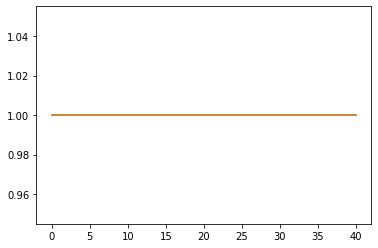

In [16]:
plt.plot(df_proxy_stats['averageMaxBufferSize'])
plt.plot(df_proxy_stats['averageActualBatchSize'])

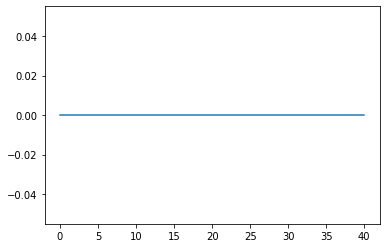

In [17]:
plt.plot(df_proxy_stats['averageTimeoutRatio'])

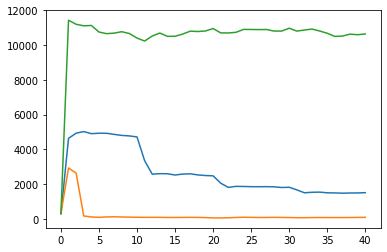

In [18]:
plt.plot(df_proxy_stats['reponseTimeAverage'])
plt.plot(df_proxy_stats['reponseTimeP50'])
plt.plot(df_proxy_stats['reponseTimeP95'])

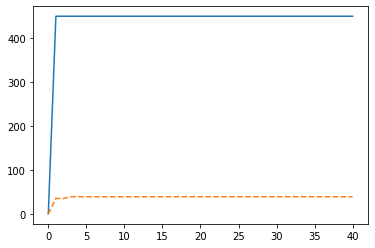

In [19]:
plt.plot(df_proxy_stats['currentReplicaCount'])
plt.plot(df_proxy_stats['currentReadyReplicaCount'], ls='--')

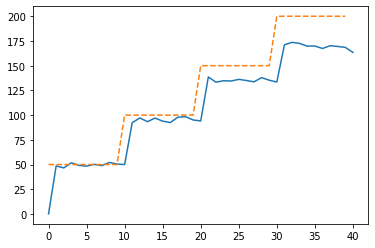

In [20]:
plt.plot(df_proxy_stats['averageArrivalRate'])
# measuremenst are once every 30s, but rps is once every minute
plt.plot(np.repeat(rps_list, 2), ls="--")